# Problem set 7: Solving the consumer problem with income risk

In [42]:
import numpy as np
import scipy as sp
from scipy import linalg
from scipy import optimize
from scipy import interpolate
import sympy as sm

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

C:\Users\sofie\AppData\Local\Temp\ipykernel_20548\1858130381.py:10: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


# Tasks

Solving the consumer problem is the **primary task** in this exercise set. You should spend most of the time you have on testing that you understand the different optimizers (problem I) and on solving the intertemporal consumption model (problem III). If for instance you are stuck in plotting, then skip ahead.   

## Optimization problem I

Consider the function

$$ 
f(\boldsymbol{x}) = f(x_1,x_2) = (x_1^2 - x_1x_2 + x_2^2)^2
$$

Define it in **sympy** by:

In [43]:
x1 = sm.symbols('x_1')
x2 = sm.symbols('x_2')
f = (x1**2 - x1*x2 + x2**2)**2

The **Jacobian** is

In [44]:
f1 = sm.diff(f,x1)
f2 = sm.diff(f,x2)
sm.Matrix([f1,f2])

Matrix([
[ (4*x_1 - 2*x_2)*(x_1**2 - x_1*x_2 + x_2**2)],
[(-2*x_1 + 4*x_2)*(x_1**2 - x_1*x_2 + x_2**2)]])

The **Hessian**  is

In [45]:
f11 = sm.diff(f,x1,x1)
f12 = sm.diff(f,x1,x2)
f21 = sm.diff(f,x2,x1)
f22 = sm.diff(f,x2,x2)
sm.Matrix([[f11,f12],[f21,f22]])

Matrix([
[      2*(2*x_1**2 - 2*x_1*x_2 + 2*x_2**2 + (2*x_1 - x_2)**2), 2*(-x_1**2 + x_1*x_2 - x_2**2 - (x_1 - 2*x_2)*(2*x_1 - x_2))],
[2*(-x_1**2 + x_1*x_2 - x_2**2 - (x_1 - 2*x_2)*(2*x_1 - x_2)),       2*(2*x_1**2 - 2*x_1*x_2 + 2*x_2**2 + (x_1 - 2*x_2)**2)]])

**Question A:** Lambdify $f(x_1,x_2)$ and use it to create: 

$(i)$ a 3D surfaceplot looking like this:

<img src="surfaceplot.png" 
     width="400" 
     height="500" />

$(ii)$ a contourplot looking like: 

<img src="contourplot.png" 
     width="400" 
     height="500" />

In [46]:
_f = sm.lambdify((x1,x2),f)
x1_grid = np.linspace(-2,2,50)
x2_grid = np.linspace(-2,2,50)
x1_mesh, x2_mesh = np.meshgrid(x1_grid,x2_grid,indexing='ij')
f_grid = _f(x1_mesh,x2_mesh)

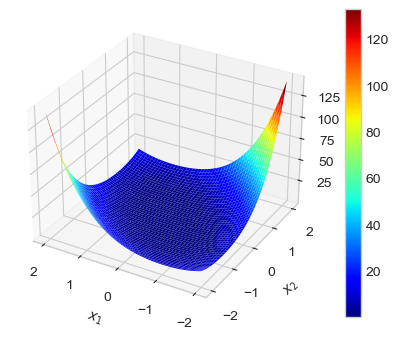

In [51]:
fig = plt.figure(dpi=100, figsize=(7,4))

ax = fig.add_subplot(projection='3d')
surface = ax.plot_surface(x1_mesh,x2_mesh,f_grid, cmap=cm.jet )
ax.invert_xaxis()
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
fig.colorbar(surface)

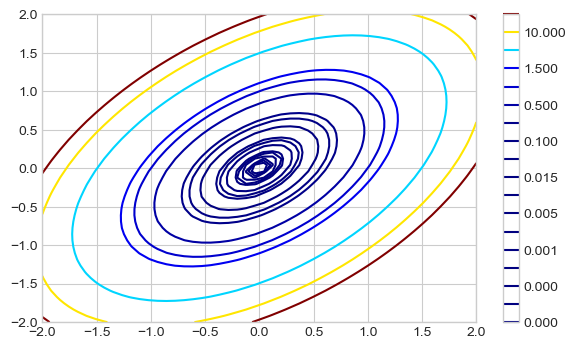

In [49]:
fig = plt.figure(dpi=100, figsize=(7,4))
ax = fig.add_subplot(1,1,1)

levels = np.sort([j*10**(-i) for i in [-1,0,1,2,3,4] for j in [0.5,1,1.5]])
contour = ax.contour(x1_grid, x2_grid, f_grid, levels=levels, cmap=cm.jet)
fig.colorbar(contour)

**Answer:** A1.py and A2.py

**Question B:** Construct python functions for the jacobian and the hessian.

In [8]:
f_python = lambda x: _f(x[0],x[1])

# Jacobian
_f1 = sm.lambdify((x1,x2),f1)
_f2 = sm.lambdify((x1,x2),f2)
jac_python = lambda x: np.array([_f1(x[0],x[1]), _f2(x[0],x[1])]) 

# Hessian
_f11 = sm.lambdify((x1,x2),f11)
_f12 = sm.lambdify((x1,x2),f12)
_f21 = sm.lambdify((x1,x2),f21)
_f22 = sm.lambdify((x1,x2),f22)
hes_python = lambda x: np.array([[_f11(x[0],x[1]), _f12(x[0],x[1])],
                                 [_f21(x[0],x[1]), _f22(x[0],x[1])]])


**Answer:** A3.py

**Question C:** Minimize $f(x_1,x_2)$ using respectively

1. Nelder-Mead,
2. BFGS without analytical jacobian,
3. BFGS with analytical jacobian, and
4. Newton-CG with analytical jacobian and hessian

Compare the results and discuss which optimizer you prefer.

**Optional:** If you wish, you can use the functions defined in the hidden cells below to also track how the optimizers converges to the solution.

In [9]:
def collect(x):
    
    # globals used to keep track across iterations
    global evals # set evals = 0 before calling optimizer
    global x0
    global x1s
    global x2s
    global fs
    
    # a. initialize list
    if evals == 0:
        x1s = [x0[0]] 
        x2s = [x0[1]]
        fs = [f_python(x0)]
        
    # b. append trial values
    x1s.append(x[0])
    x2s.append(x[1])
    fs.append(f_python(x))
    
    # c. increment number of evaluations
    evals += 1

In [10]:
def contour():
    
    global evals
    global x1s
    global x2s
    global fs
    
    # a. contour plot
    fig = plt.figure(figsize=(10,4))
    ax = fig.add_subplot(1,2,1)
    levels = np.sort([j*10**(-i) for i in [-1,0,1,2,3,4] for j in [0.5,1,1.5]])
    cs = ax.contour(x1_grid,x2_grid,f_grid,levels=levels,cmap=cm.jet)
    fig.colorbar(cs)
    ax.plot(x1s,x2s,'-o',ms=4,color='black')
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    
    # b. function value
    ax = fig.add_subplot(1,2,2)
    ax.plot(np.arange(evals+1),fs,'-o',ms=4,color='black')
    ax.set_xlabel('iteration')
    ax.set_ylabel('function value')

 final_simplex: (array([[ 5.42964698e-06,  3.66053376e-05],
       [-2.91186614e-05, -4.46522598e-05],
       [-6.68498608e-05,  4.62439228e-06]]), array([1.37048639e-18, 2.37624294e-18, 2.30345175e-17]))
           fun: 1.370486388165964e-18
       message: 'Optimization terminated successfully.'
          nfev: 83
           nit: 43
        status: 0
       success: True
             x: array([5.42964698e-06, 3.66053376e-05])


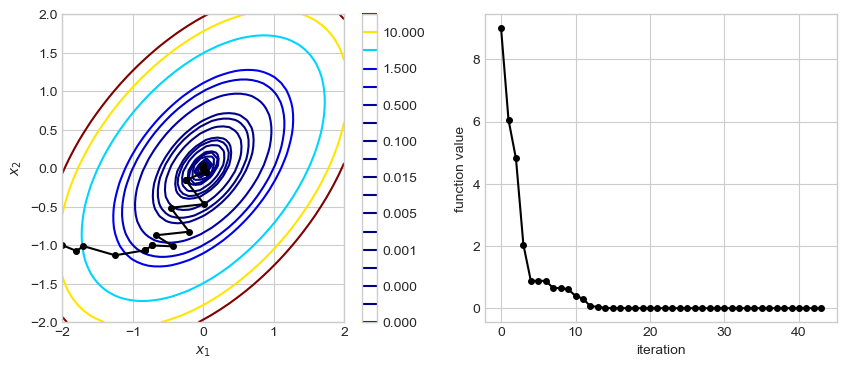

In [11]:
x0 = [-2,-1] # suggested initial guess

# Nelder-mead
evals = 0
res_nm = optimize.minimize(f_python, x0, method='nelder-mead', callback=collect)
print(res_nm)
contour()

# The convergence path is jagged and jumps around - but eventually, we get to the bottom.

      fun: 2.415548501835971e-08
 hess_inv: array([[134.40627949, -76.13420524],
       [-76.13420524, 232.06465901]])
      jac: array([ 7.24026953e-06, -1.22532541e-06])
  message: 'Optimization terminated successfully.'
     nfev: 84
      nit: 26
     njev: 28
   status: 0
  success: True
        x: array([0.01421434, 0.00513617])


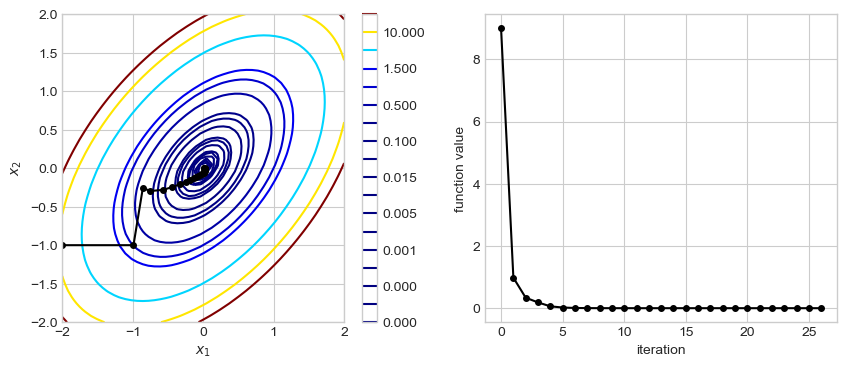

In [12]:
# BFGS without analytical Jacobian
evals=0
res_bfgs_num = optimize.minimize(f_python, x0, method='bfgs', callback=collect)
print(res_bfgs_num)
contour()

# Much smoother convergence path - however, the number of function evaluations is much higher 
# than the number of iterations. This is because the algorithm has to evaluate the function in
# order to compute the (approximated) gradient.


In [53]:
# BFGS with analytical Jacobian
evals=0
res_bfgs_jac = optimize.minimize(f_python,x0,method='bfgs', jac=jac_python,callback=collect)
print(res_bfgs_jac)
#contour()

# Same convergence path - but lower number of function evaluations. Now the algorithm can just compute
# the gradient directly, which speeds up things.

      fun: 1.3700358787514183e-17
 hess_inv: array([[ 8936210.08057983,  1406051.17593617],
       [ 1406051.17593617, 30807682.32185194]])
      jac: array([ 7.81296187e-13, -2.43651863e-15])
  message: 'Optimization terminated successfully.'
     nfev: 57
      nit: 55
     njev: 57
   status: 0
  success: True
        x: array([7.02507176e-05, 3.49607914e-05])


     fun: 2.158963057079746e-09
     jac: array([-6.3345228e-07, -6.3345228e-07])
 message: 'Optimization terminated successfully.'
    nfev: 15
    nhev: 15
     nit: 15
    njev: 15
  status: 0
 success: True
       x: array([-0.0068165, -0.0068165])


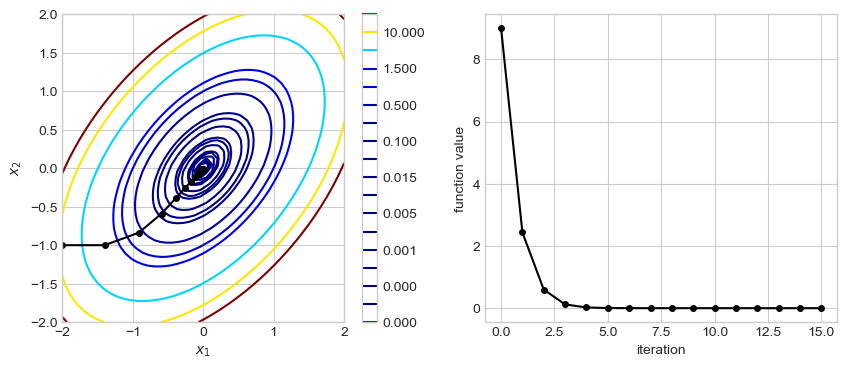

In [14]:
# Newton-CG with analytical Jacobian and Hessian
evals=0
res_newton = optimize.minimize(f_python,x0,method='newton-cg',jac=jac_python,hess=hes_python,callback=collect)
print(res_newton)
contour()

# VERY fast convergence!

In [15]:
print(res_nm.x)
print(res_bfgs_num.x)
print(res_bfgs_jac.x)
print(res_newton.x)

[5.42964698e-06 3.66053376e-05]
[0.01421434 0.00513617]
[0.0142144  0.00513621]
[-0.0068165 -0.0068165]


In [16]:
# Note also that even though all of the optimizers converge to a point with a function vallue of approx. 0, 
# they somewhat disagree on what that exact point is.
# If the function is very flat around the optimum, it is hard to find the exact optimum!
# Sometimes decreasing the tolerance (convergence criterion) can mitigate this issue, but some
# imprecision can be expected.

**Answer:** A4.py, A5.py, A6.py, A7.py

## Optimization problem II

Consider the function

$$
f(x_1,x_2) = (4-2.1x_1^2 + \frac{x_1^4}{3})x_1^2 + x_1x_2 + (4x_2^2 - 4)x_2^2)
$$

Define it in **sympy** by:

In [17]:
x1 = sm.symbols('x_1')
x2 = sm.symbols('x_2')
f = (4-2.1*x1**2 + (x1**4)/3)*x1**2 + x1*x2 + (4*x2**2 - 4)*x2**2
_f = sm.lambdify((x1,x2),f)
f

x_1**2*(x_1**4/3 - 2.1*x_1**2 + 4) + x_1*x_2 + x_2**2*(4*x_2**2 - 4)

Create **3D plot**:

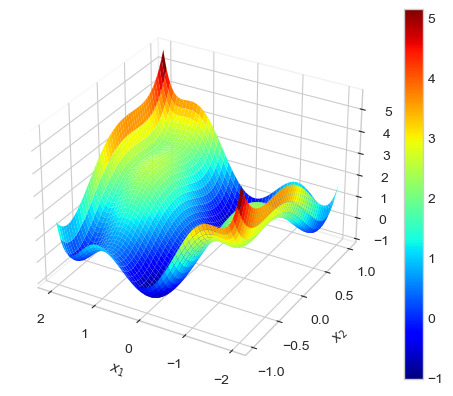

In [18]:
# a. grids
x1_vec = np.linspace(-2,2,500)
x2_vec = np.linspace(-1,1,500)
x1_grid,x2_grid = np.meshgrid(x1_vec,x2_vec,indexing='ij')
f_grid = _f(x1_grid,x2_grid)

# b. main
fig = plt.figure()
ax = fig.add_subplot(1,1,1,projection='3d')
cs = ax.plot_surface(x1_grid,x2_grid,f_grid,cmap=cm.jet)

# c. add labels
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_zlabel('$f$')

# d. invert xaxis
ax.invert_xaxis()

# e. remove background
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

# f. add colorbar
fig.colorbar(cs);

**Question A:** Find the minimum of the function starting from each of the suggested initial values below. Print the first 20 solutions, and all solutions aftwards, which is the best yet to be found. Save the solutions and associated function values in `xs` and `fs`.

In [19]:
# a. python function for f
f_python = lambda x: _f(x[0],x[1])

# b. initial guesses
np.random.seed(1986)
K = 1000
x0s = np.empty((K,2))
x0s[:,0] = -2 + 4*np.random.uniform(size=K)
x0s[:,1] = -1 + 2*np.random.uniform(size=K)

# c. solutions and associated values
xs = np.empty((K,2))
fs = np.empty(K)

x_best = np.zeros(2) + np.nan
f_best = -np.inf

# write your code here
for i,x0 in enumerate(x0s):
    res = optimize.minimize(f_python, x0, method='bfgs')
    xs[i]=res.x
    fs[i]=res.fun

    if res.fun < f_best:
        f_best = res.fun
        x_best = res.x

    if i < 20 or res.fun == f_best:
        print(f'Iteration {i}: Optimum found at {res.x} with f(x)={res.fun:5.2f}')

Iteration 0: Optimum found at [ 0.0898409  -0.71265642] with f(x)=-1.03
Iteration 1: Optimum found at [-1.70360667  0.7960836 ] with f(x)=-0.22
Iteration 2: Optimum found at [ 0.08984206 -0.71265642] with f(x)=-1.03
Iteration 3: Optimum found at [ 1.70360671 -0.79608356] with f(x)=-0.22
Iteration 4: Optimum found at [ 0.08984199 -0.71265641] with f(x)=-1.03
Iteration 5: Optimum found at [-0.08984197  0.71265636] with f(x)=-1.03
Iteration 6: Optimum found at [-0.08984117  0.71265648] with f(x)=-1.03
Iteration 7: Optimum found at [ 0.08984201 -0.71265642] with f(x)=-1.03
Iteration 8: Optimum found at [-0.08984093  0.712656  ] with f(x)=-1.03
Iteration 9: Optimum found at [-0.08984209  0.71265649] with f(x)=-1.03
Iteration 10: Optimum found at [-0.08984171  0.71265645] with f(x)=-1.03
Iteration 11: Optimum found at [ 1.70360671 -0.79608356] with f(x)=-0.22
Iteration 12: Optimum found at [ 0.08984301 -0.71265666] with f(x)=-1.03
Iteration 13: Optimum found at [ 0.089842  -0.7126564] with f

**Answer:** A8.py

**Question B:** Create a 3D scatter plot of where the optimizer converges, and color the dots by the associated function values.

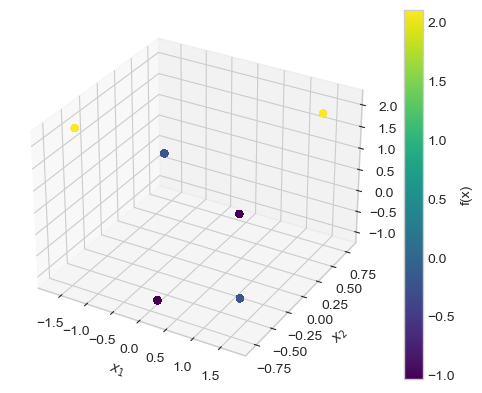

In [20]:
# write your code here
x1 = xs[:,0]
x2 = xs[:,1]

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
scatter = ax.scatter(x1,x2, fs, c=fs,cmap='viridis')
fig.colorbar(scatter, label='f(x)')

ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$');

**Answer:** A9.py

**Question C:** Plot the function values at the solutions as a function of the starting values.

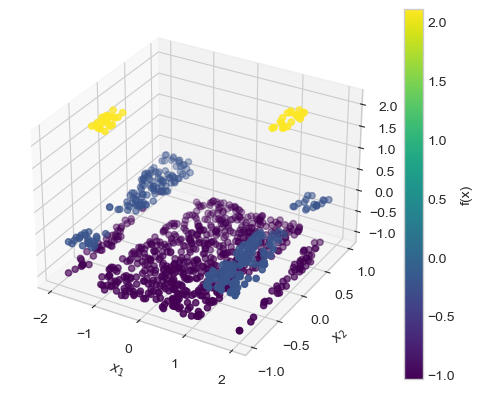

In [21]:
# write your code here
x1 = x0s[:,0]
x2 = x0s[:,1]

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
scatter = ax.scatter(x1,x2, fs, c=fs,cmap='viridis')
fig.colorbar(scatter, label='f(x)')

ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$');

**Answer:** A10.py

# Problem: Solve the consumer problem with income risk I

Define the following **variables** and **parameters**:

* $m_t$ is cash-on-hand in period $t$
* $c_t$ is consumption in period $t$
* $y_t$ is income in period $t$
* $\Delta \in (0,1)$ is income risk
* $r$ is the interest rate
* $\beta > 0$, $\rho > 1$, $\nu > 0 $, $\kappa > 0$, $\xi > 0$ are utility parameters

In the **second period** the household solves:

$$
\begin{aligned}
v_{2}(m_{2}) &= \max_{c_{2}}\frac{c_{2}^{1-\rho}}{1-\rho}+\nu\frac{(m_{2}-c_{2}+\kappa)^{1-\rho}}{1-\rho} \\
 \text{s.t.} \\
c_{2} & \in [0,m_{2}]
\end{aligned}
$$

In the **first period** the household solves:

$$
\begin{aligned}
v_{1}(m_{1}) & = 
\max_{c_{1}}\frac{c_{1}^{1-\rho}}{1-\rho}+\beta\mathbb{E}_{1}\left[v_2(m_2)\right] \\
\text{s.t.} \\
m_2 &= (1+r)(m_{1}-c_{1})+y_{2} \\
y_{2} &= \begin{cases}
1-\Delta & \text{with prob. }0.5\\
1+\Delta & \text{with prob. }0.5 
\end{cases}\\
c_{1} & \in [0,m_{1}]\\
\end{aligned}
$$

The **basic functions** are:

In [22]:
def utility(c,rho):
    return c**(1-rho)/(1-rho)

def bequest(m,c,nu,kappa,rho):
    return nu*(m-c+kappa)**(1-rho)/(1-rho)

def v2(c2,m2,rho,nu,kappa):
    return utility(c2,rho) + bequest(m2,c2,nu,kappa,rho)

def v1(c1,m1,rho,beta,r,Delta,v2_interp):
    
    # a. v2 value, if low income
    m2_low = (1+r)*(m1-c1) + 1-Delta
    v2_low = v2_interp([m2_low])[0]
    
    # b. v2 value, if high income
    m2_high = (1+r)*(m1-c1) + 1+Delta
    v2_high = v2_interp([m2_high])[0]
    
    # c. expected v2 value
    v2 = 0.5*v2_low + 0.5*v2_high
    
    # d. total value
    return utility(c1,rho) + beta*v2

The **solution functions** are:

In [23]:
def solve_period_2(rho,nu,kappa,Delta):

    # a. grids
    m2_vec = np.linspace(1e-8,5,500)
    v2_vec = np.empty(500)
    c2_vec = np.empty(500)

    # b. solve for each m2 in grid
    for i,m2 in enumerate(m2_vec):

        # i. objective
        obj = lambda x: -v2(x[0],m2,rho,nu,kappa)

        # ii. initial value (consume half)
        x0 = m2/2

        # iii. optimizer
        result = optimize.minimize(obj,[x0],method='L-BFGS-B',bounds=((1e-12,m2),))

        # iv. save
        v2_vec[i] = -result.fun
        c2_vec[i] = result.x[0]
        
    return m2_vec,v2_vec,c2_vec

def solve_period_1(rho,beta,r,Delta,v1,v2_interp):

    # a. grids
    m1_vec = np.linspace(1e-8,4,100)
    v1_vec = np.empty(100)
    c1_vec = np.empty(100)
    
    # b. solve for each m1 in grid
    for i,m1 in enumerate(m1_vec):
        
        # i. objective
        obj = lambda x: -v1(x[0],m1,rho,beta,r,Delta,v2_interp)
        
        # ii. initial guess (consume half)
        x0 = m1/2
        
        # iii. optimize
        result = optimize.minimize(obj,[x0],method='L-BFGS-B',bounds=((1e-12,m1),))
        
        # iv. save
        v1_vec[i] = -result.fun
        c1_vec[i] = result.x[0]
     
    return m1_vec,v1_vec,c1_vec

**Question A:** Find optimal consumption in the first period as funcition of cash-on-hand, and plot it.

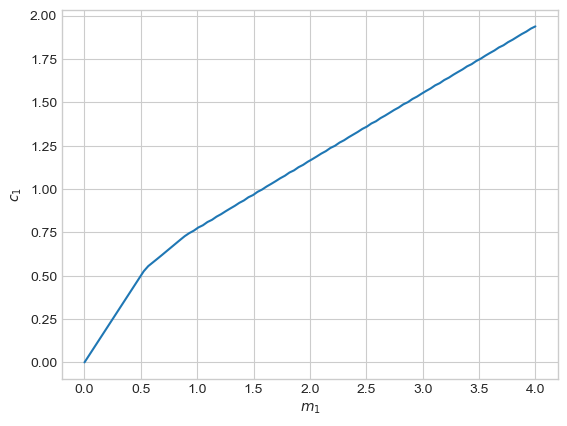

In [24]:
rho = 8
kappa = 0.5
nu = 0.1
r = 0.04
beta = 0.94
Delta = 0.5

# b. solve

# b.1 solve period 2
m2_vec,v2_vec,c2_vec = solve_period_2(rho, nu, kappa, Delta)


# b.2 make period 2 consumption function by interpolating over solution
v2_interp = interpolate.RegularGridInterpolator([m2_vec],v2_vec, bounds_error=False, fill_value=None)
    # note: v2_interp is now a function, such that v2_interp(0.5) gives the value of 0.5 cash-on-hand in period 2

# b.3 solve period 1, using the interpolated period 2 value function
m1_vec,v1_vec,c1_vec = solve_period_1(rho,beta,r,Delta,v1,v2_interp)

# c. plot
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(m1_vec, c1_vec)
ax.set_xlabel('$m_1$')
ax.set_ylabel('$c_1$');


**Answer:** A11.py

**Question B:** Find optimal consumption in the first period as funcition of cash-on-hand, and plot it, assuming that

$$ 
y_{2} = \begin{cases}
1-\sqrt{\Delta} & \text{with prob. }0.1\\
1-\Delta & \text{with prob. }0.4\\
1+\Delta & \text{with prob. }0.4\\ 
1+\sqrt{\Delta} & \text{with prob. }0.1
\end{cases}
$$

which add some low probability tail events, but does not change mean income. Give an interpretation of the change in the consumption function.

Text(0, 0.5, '$c_1$')

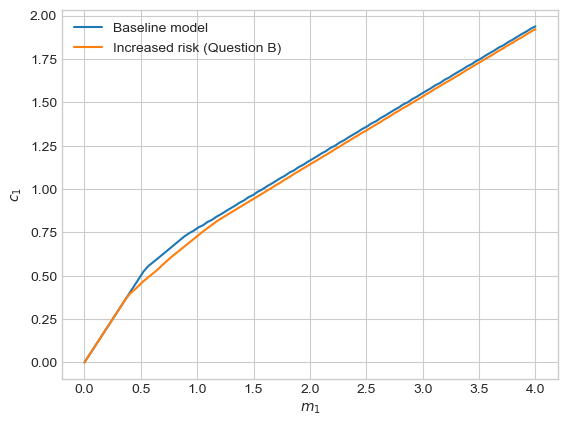

In [25]:
# Given cash-on-hand, the solution in period 2 is the same as the previous problem, so we can just reuse
# solve_period_2 and the v2-interpolater from earlier.
# The value in period 1 changes, because there is more uncertainty about the future
# Otherwise, the problem is the same

def v1_qb(c1,m1,rho,beta,r,Delta,v2_interp):
    
    # a. v2 value, if very low income
    m2_vlow = (1+r)*(m1-c1) + 1 - np.sqrt(Delta)
    v2_vlow = v2_interp([m2_vlow])[0]

    # b. v2 value, if low income
    m2_low = (1+r)*(m1-c1) + 1-Delta
    v2_low = v2_interp([m2_low])[0]
    
    # c. v2 value, if high income
    m2_high = (1+r)*(m1-c1) + 1+Delta
    v2_high = v2_interp([m2_high])[0]

    # d. v2 value, if very high income
    m2_vhigh = (1+r)*(m1-c1) + 1+np.sqrt(Delta)
    v2_vhigh = v2_interp([m2_vhigh])[0]
    
    # c. expected v2 value
    v2 = 0.1*v2_vlow + 0.4*v2_low + 0.4*v2_high + 0.1*v2_vhigh
    
    # d. total value
    return utility(c1,rho) + beta*v2


# Solve period 1 with new period 1 value function
m1_vec_qb,v1_vec_qb,c1_vec_qb = solve_period_1(rho,beta,r,Delta,v1_qb,v2_interp)

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(m1_vec, c1_vec, label='Baseline model')
ax.plot(m1_vec_qb, c1_vec_qb, label='Increased risk (Question B)')
ax.legend()
ax.set_xlabel('$m_1$')
ax.set_ylabel('$c_1$')

# higher risk reduces consumption - precautionary savings

**Answer:** A12.py

# Problem: Solve the consumer problem with income risk II

Define the following **variables** and **parameters**:

* $m_t$ is cash-on-hand in period $t$
* $c_t$ is non-durable consumption in period $t$
* $d_t$ is durable consumption in period $t$ (only adjustable in period 1)
* $y_t$ is income in period $t$
* $\Delta \in (0,1)$ is income risk
* $r$ is the interest rate
* $\beta > 0$, $\rho > 1$, $\alpha \in (0,1)$, $\nu > 0 $, $\kappa > 0$, $\xi > 0$ are utility parameters

In the **second period** the household solves:

$$
\begin{aligned}
v_{2}(m_{2},d_{2}) &= \max_{c_{2}}\frac{c_{2}^{1-\rho}}{1-\rho}+\alpha\frac{d_{2}^{1-\rho}}{1-\rho}+\nu\frac{(m_{2}+d_{2}-c_{2}+\kappa)^{1-\rho}}{1-\rho} \\
\text{s.t.} \\
c_{2} & \in [0,m_{2}]
\end{aligned}
$$

In the **first period** the household solves:

$$
\begin{aligned}
v_{1}(m_{1}) &= \max_{c_{1},d_{1}}\frac{c_{1}^{1-\rho}}{1-\rho}+\alpha\frac{d_{1}^{1-\rho}}{1-\rho}+\beta\mathbb{E}_{1}\left[v_2(m_2,d_2)\right]\\&\text{s.t.}&\\
m_2 &= (1+r)(m_{1}-c_{1}-d_{1})+y_{2} \\
y_{2} &= \begin{cases}
1-\Delta & \text{with prob. }0.5\\
1+\Delta & \text{with prob. }0.5 
\end{cases}\\
c_{1}+d_{1} & \in [0,m_{1}]\\
\end{aligned}
$$

Choose **parameters**:

In [26]:
rho = 2
alpha = 0.1
kappa = 0.5
nu = 0.1
r = 0.04
beta = 0.94
Delta = 0.5

The **basic functions** are:

In [27]:
def utility(c,d,alpha,rho):
    return c**(1-rho)/(1-rho) + alpha*d**(1-rho)/(1-rho)

def bequest(m,c,d,nu,kappa,rho):
    return nu*(m+d-c+kappa)**(1-rho)/(1-rho)

def v2(c2,d2,m2,alpha,rho,nu,kappa):
    return utility(c2,d2,alpha,rho) + bequest(m2,c2,d2,nu,kappa,rho)

def v1(c1,d1,m1,alpha,rho,beta,r,Delta,v2_interp):
    
    # a. v2 value, if low income
    m2_low = (1+r)*(m1-c1-d1) + 1-Delta
    v2_low = v2_interp([m2_low,d1])[0]
    
    # b. v2 value, if high income
    m2_high = (1+r)*(m1-c1-d1) + 1+Delta
    v2_high = v2_interp([m2_high,d1])[0]
    
    # c. expected v2 value
    v2 = 0.5*v2_low + 0.5*v2_high
    
    # d. total value
    return utility(c1,d1,alpha,rho) + beta*v2

The **solution function for period 2** is:

In [28]:
def solve_period_2(alpha,rho,nu,kappa,Delta):

    # a. grids
    m2_vec = np.linspace(1e-8,5,200)
    d2_vec = np.linspace(1e-6,5,100)
    v2_grid = np.empty((200,100))
    c2_grid = np.empty((200,100))

    # b. solve for each m2 in grid
    for i,m2 in enumerate(m2_vec):
        for j,d2 in enumerate(d2_vec):

            # i. objective
            obj = lambda x: -v2(x[0],d2,m2,alpha,rho,nu,kappa)

            # ii. initial value (consume half)
            x0 = m2/2

            # iii. optimizer
            result = optimize.minimize(obj,[x0],method='L-BFGS-B',bounds=((1e-12,m2),))

            # iv. save
            v2_grid[i,j] = -result.fun
            c2_grid[i,j] = result.x[0]
        
    return m2_vec,d2_vec,v2_grid,c2_grid

**Question A:** Solve for consumption in period 2 and plot the consumption function.

In [29]:
# In period 2, we have two state variables: Cash-on-hand (m2) and durable good (d2). Instead of solving
# over a vector of one state variable, we must solve over a grid of two state variables.
m2_vec,d2_vec,v2_grid,c2_grid=solve_period_2(alpha,rho,nu,kappa,Delta)
    # Note: this function solves 200x100 optimization problems, one for each point in the m2Xd2 grid,
    # so this will take some time. Models like this one are why we care about the speed of the optimization
    # algorithm!
    
# We use the solution to interpolate over the value function grid
v2_interp = interpolate.RegularGridInterpolator((m2_vec, d2_vec), v2_grid, bounds_error=False, fill_value=None)

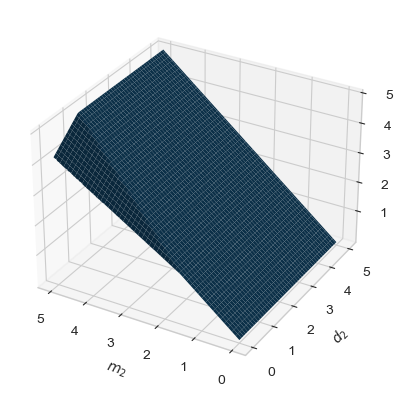

In [30]:
# Plot the consumption function
m2_mesh, d2_mesh = np.meshgrid(m2_vec, d2_vec, indexing='ij')

fig = plt.figure()
ax = fig.add_subplot(1,1,1, projection='3d')
ax.plot_surface(m2_mesh, d2_mesh, c2_grid)
ax.set_xlabel('$m_2$')
ax.set_ylabel('$d_2$')
ax.set_zlabel('$c_2$')
ax.invert_xaxis()

**Answer:** A13.py

**Question B:** Find optimal consumption and choices of durables in the first period as a function of cash-on-hand and plot it.

In [31]:
# Solve in period 1
def solve_period_1(rho,beta,r,Delta,v1,v2_interp):

    # grids
    m1_vec = np.linspace(1e-8,5,100)
    v1_vec = np.empty((100))
    c1_vec = np.empty((100))
    d1_vec = np.empty((100))

    # Solve for ieach point in the grid:
    for i_m,m1 in enumerate(m1_vec):

        # define objective function
        obj = lambda x: -v1(x[0],x[1],m1,alpha,rho,beta,r,Delta,v2_interp)

        # initial guess: consume half evenly split 
        c0 = m1/4
        d0 = m1/4
        
        # borrowing constraint
        ineq_con = {'type': 'ineq', 'fun': lambda x: m1-x[0]-x[1]} 

        # optimize
        res = optimize.minimize(obj,(c0,d0),method='SLSQP', 
                                constraints=ineq_con,
                                bounds=((1e-12,m1),((1e-12,m1))))
        
        # store values  
        c1_vec[i_m] = res.x[0]
        d1_vec[i_m] = res.x[1]
        v1_vec[i_m] = -res.fun

    return m1_vec,v1_vec,c1_vec,d1_vec

m1_vec,v1_vec,c1_vec,d1_vec=solve_period_1(rho,beta,r,Delta,v1,v2_interp)

c:\Users\sofie\anaconda3\lib\site-packages\scipy\optimize\_optimize.py:284: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


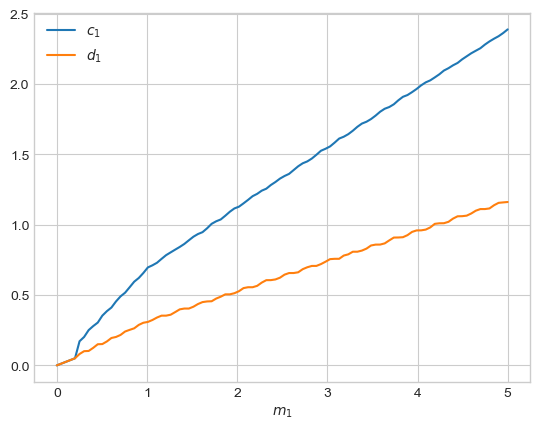

In [32]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

ax.plot(m1_vec, c1_vec, label='$c_1$')
ax.plot(m1_vec, d1_vec, label='$d_1$')
ax.set_xlabel('$m_1$')
ax.legend();

**Answer:** A14.py

# Extra Problems

**Simulate** a distribution of consumers in either of the two consumption-saving models above. See **section 6.3 in lecture 11** regarding 
how this is done.

In [37]:
## I simulate the durable goods model.

# set simulation parameters
simN = 1_000
np.random.seed(2106)

# 1. Initialize 1_000 agents with cash on hand drawn from a uniform distribution
m_min = 1
m_max = 5
m_ini = np.random.uniform(m_min, m_max, simN)


# 0. Period 1 choices: by looking up in the solution grids - here we have to interpolate between grid points again 
c1_interpolator = interpolate.RegularGridInterpolator([m1_vec], c1_vec, 
                                                      method='linear', 
                                                      bounds_error=False, 
                                                      fill_value=None)
d1_interpolator = interpolate.RegularGridInterpolator([m1_vec], d1_vec, 
                                                      method='linear', 
                                                      bounds_error=False, 
                                                      fill_value=None)
c1_sim = c1_interpolator(m_ini)
d1_sim = d1_interpolator(m_ini)

# 2. State transition
# 2.a: Simulate period 2 income by randomly drawing values of y2
y2_sim = np.random.choice([1-Delta, 1+Delta], size=simN, p=(0.5,0.5))
# 2.b: Compute period 2 cash on hand from period 1 choices and simulated y2
m2_sim = (1+r)*(m_ini - c1_sim - d1_sim) + y2_sim
d2_sim = d1_sim

# 3. Period 2 choices: same procedure as period 1
c2_interpolator = interpolate.RegularGridInterpolator([m2_vec, d2_vec], c2_grid, 
                                                      method='linear', 
                                                      bounds_error=False, 
                                                      fill_value=None)
c2_sim = c2_interpolator((m2_sim, d2_sim))


(0.0, 2.5)

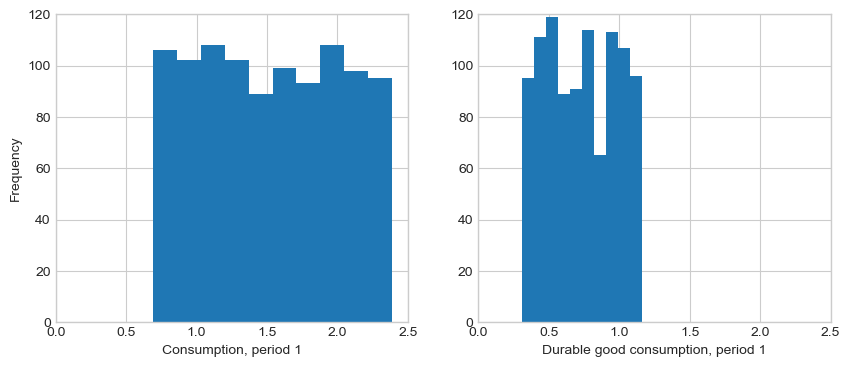

In [38]:
# we can use the simulation to explore the results!
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(1,2,1)
ax.hist(c1_sim)
ax.set_ylabel('Frequency')
ax.set_xlabel('Consumption, period 1')
ax.set_ylim(0,120)
ax.set_xlim(0, 2.5)

ax = fig.add_subplot(1,2,2)
ax.hist(d1_sim)
ax.set_xlabel('Durable good consumption, period 1')
ax.set_ylim(0,120)
ax.set_xlim(0, 2.5)

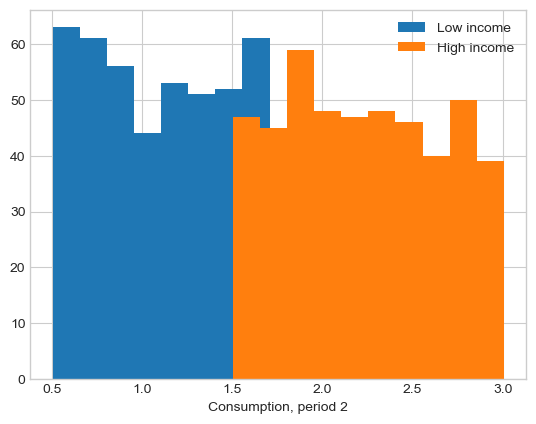

In [40]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.hist(c2_sim[y2_sim==0.5], label='Low income')
ax.hist(c2_sim[y2_sim==1.5], label='High income')
ax.set_xlabel('Consumption, period 2')
ax.legend();